In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import re
import scipy.sparse as sparse
import seaborn as sns
import time
import warnings
import boto3


from scipy import interpolate
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

%matplotlib inline
warnings.filterwarnings('ignore')

In [24]:
raw_data_filename = 'downloads/cleaned.csv'
df = pd.read_csv(raw_data_filename, parse_dates=[6])

In [25]:
df.user_screen_name = df.user_screen_name.str.lower()
def clean_tweet(text):
    ext = "http"
    tweet = text[:text.find(ext)].lower()
    tweet = re.sub("[^\S]", " ", tweet)
    tweet = re.sub("english translation ", "", tweet)
    textOnly = re.sub("[^a-zA-Z0-9@# ]", "", tweet)
    return(textOnly)

In [26]:
df.texts = df.text.apply(lambda x :clean_tweet)
keep_col = ['id', 'parsed_created_at', 'user_screen_name', 'text','user_followers_count','user_statuses_count', 'tweet_type', 'coordinates', 'hashtags', 'user_location', 'user_name', 'user_verified']
df=df[keep_col]
df.head()

,id,parsed_created_at,user_screen_name,text,user_followers_count,user_statuses_count,tweet_type,coordinates,hashtags,user_location,user_name,user_verified
0,1230472014130892800,2020-02-20T12:39:23+00:00,digit96,RT @W7VOA: #Singapore confirms first case with...,1933,368281,retweet,NaN,Singapore COVID19 coronavirus dengue,서울특별시 동대문구& 東京都 目黒区& 부산광역시 수영구,종이나무 Papertree,False
1,1230472009605406720,2020-02-20T12:39:22+00:00,coronahelps,#BREAKING: YouTube video about the CDC hiding ...,4,35,original,NaN,BREAKING coronavirus WuhanCoronavirus COVID19 ...,NaN,Coronahelps,False
2,1230472003301335041,2020-02-20T12:39:21+00:00,tr1897gmailcom3,"1. Wuhan 2. Qom, Iran 3. Daegu, South Korea 4...",8,47,original,NaN,coronavirus COVID19,"Weston, FL",Tom Ryan,False
3,1230472001439051776,2020-02-20T12:39:20+00:00,meste48,RT @BogochIsaac: Two elderly people succumbed ...,1530,39776,retweet,NaN,covid19,NaN,maria eugenia este,False
4,1230471998704422913,2020-02-20T12:39:20+00:00,starid23,RT @Finanzas_Time: #Coronavirus #COVID19 ☣️ C...,7,344,retweet,NaN,Coronavirus COVID19,"Lima, Peru",Cesar Gamarra,False


In [27]:
pd.options.mode.chained_assignment = None

mentions = df.loc[df.text.str.contains('@', na=False)]
mentions['Tagged User'] = mentions.text.apply(lambda x: re.findall(r'@([A-Za-z0-9_]+)',str(x)))
users = mentions.user_name.unique()
mentions['Tagged User Cnt'] = mentions['Tagged User'].apply(lambda x: list(set(x).intersection(users)) )
mentions['Cnt length'] = mentions['Tagged User Cnt'].apply(lambda x: len(x))

for i in range(len(mentions.text)):
    row = mentions.iloc[i,:]
    
    
    for j in range(len(row['Tagged User'])):
        tmp = pd.DataFrame({'User':[row['user_name']],
                            'Mentions':[row['Tagged User'][j]],
                            'Time': [row['parsed_created_at']],
                            'User num status':[row['user_statuses_count']],
                            'Followers':[row['user_followers_count']],
                            'Weight': [1]})
        if i==0 and j==0:
            mention_net = tmp
        else:
            mention_net = mention_net.append(tmp, ignore_index=True)
            
mention_net = mention_net[mention_net['User']!=mention_net['Mentions']].reset_index(drop=True)
mention_net.head(5)

,User,Mentions,Time,User num status,Followers,Weight
0,종이나무 Papertree,W7VOA,2020-02-20T12:39:23+00:00,368281,1933,1
1,maria eugenia este,BogochIsaac,2020-02-20T12:39:20+00:00,39776,1530,1
2,Cesar Gamarra,Finanzas_Time,2020-02-20T12:39:20+00:00,344,7,1
3,Amit Jain,bsindia,2020-02-20T12:39:19+00:00,4926,249,1
4,redditchgardener,DarrenPlymouth,2020-02-20T12:39:18+00:00,12953,1192,1


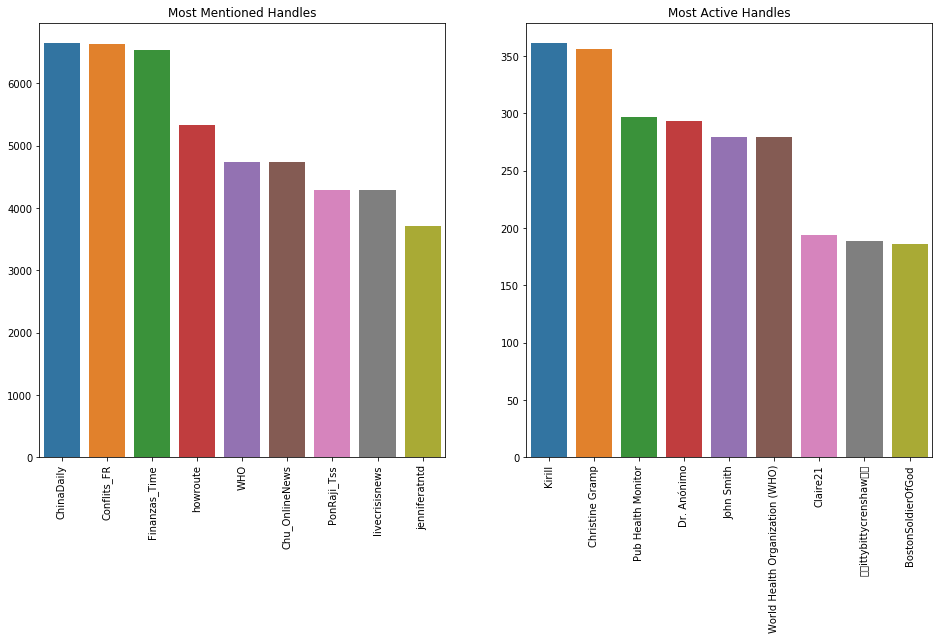

In [28]:
most_mentions = mention_net.Mentions.value_counts().sort_values(ascending=False)
most_active = mention_net.User.value_counts().sort_values(ascending=False)

plt.figure(figsize=(16,8))
ax1 = plt.subplot(121)
ax1 = sns.barplot(most_mentions[0:9].index, most_mentions[0:9].values)
ax1 = plt.title("Most Mentioned Handles")
ax1 =plt.xticks(rotation=90)
ax2 = plt.subplot(122)
ax2 = sns.barplot(most_active[0:9].index, most_active[0:9].values)
ax2 = plt.title("Most Active Handles")
ax2 =plt.xticks(rotation=90)
plt.show()

In [29]:
network = mention_net.iloc[:,[0,1,5]] #Use the mentions, user, and weight columns to bulid the network
print(network)
network = network.groupby(by=['Mentions','User'],as_index='False')['Weight'].sum().reset_index(name='Weight')
network= pd.DataFrame(network).sort_values(by='Weight',ascending=False).reset_index(drop=True)
network = network[network['Weight']>20]

print('Most frequent user/mention pairs:')
network.head(10)

                      User        Mentions  Weight
0           종이나무 Papertree           W7VOA       1
1       maria eugenia este     BogochIsaac       1
2            Cesar Gamarra   Finanzas_Time       1
3                Amit Jain         bsindia       1
4         redditchgardener  DarrenPlymouth       1
...                    ...             ...     ...
188221             yumi　ゆみ      DrEricDing       1
188222   tabøreciara 🌷🌼🌺🌻🌹      dailynaver       1
188223          Damiendoza   Finanzas_Time       1
188224     dreamvillaorion      DrEricDing       1
188225                  AF        julio7rc       1

[188226 rows x 3 columns]
Most frequent user/mention pairs:


,Mentions,User,Weight
0,Finanzas_Time,Anto lo,138
1,Finanzas_Time,Dr. Anónimo,115
2,Finanzas_Time,T 1,108
3,DrTedros,World Health Organization (WHO),102
4,chrismartenson,Memento Mori,87
5,Finanzas_Time,TAURUS,84
6,Conflits_FR,Brest Newzh ✊🇫🇷🇪🇺🌍,77
7,Conflits_FR,Genevieve Grimaud,77
8,Conflits_FR,Johan Weylland 🇫🇷 🇺🇸,74
9,Finanzas_Time,Ultraderecha 🇺🇸🇧🇷,73


(-1.108365113333715,
 1.1353563891931373,
 -1.105456345362919,
 1.1054563490233287)

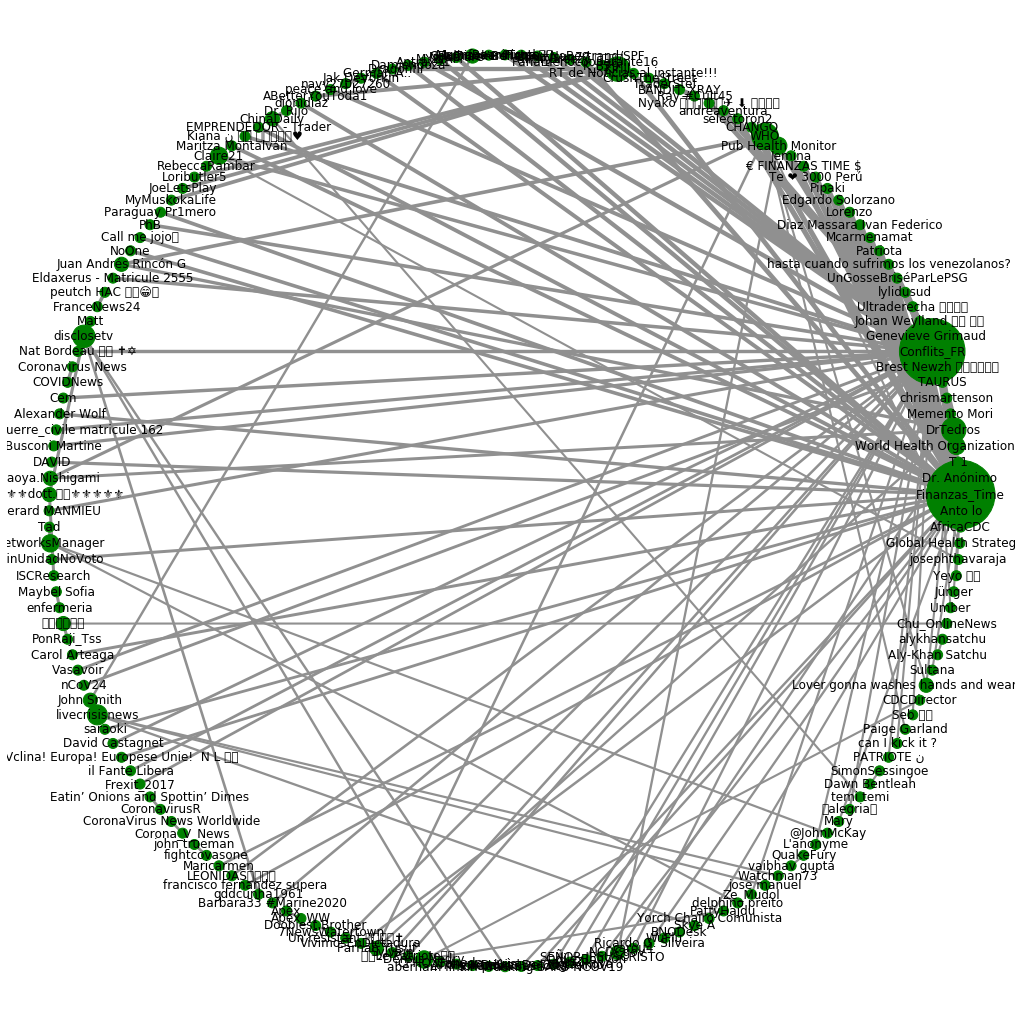

In [31]:
G = nx.Graph()
for i in range(len(network['User'])):
    G.add_edge(network['User'][i],network['Mentions'][i],weight=network['Weight'][i])
    
plt.figure(figsize=(14,14))
d=list(nx.degree(G))
weights = [G.edges[u, v]['weight']/10 for u, v in G.edges()]
size = [d[:][v][1]*100 for v in range(len(d))]

nx.draw_circular(G,node_color='g', node_size=size, edge_color='#909090', with_labels=True, width=weights)
plt.axis('equal')

In [32]:
from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource, LabelSet
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

plot = Plot(plot_width=1000, plot_height=1000, x_range=Range1d(-1.1,1.1), y_range=Range1d(-1.1,1.1))
plot.title.text = "Graph Interaction Demonstration"

plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())

graph_renderer = from_networkx(G, nx.circular_layout, scale=1, center=(0,0))

graph_renderer.node_renderer.glyph = Circle(size=15, fill_color=Spectral4[0])
graph_renderer.node_renderer.selection_glyph = Circle(size=15, fill_color=Spectral4[2])
graph_renderer.node_renderer.hover_glyph = Circle(size=15, fill_color=Spectral4[1])

graph_renderer.edge_renderer.glyph = MultiLine(line_color="#CCCCCC", line_alpha=0.8, line_width=5)
graph_renderer.edge_renderer.selection_glyph = MultiLine(line_color=Spectral4[2], line_width=5)
graph_renderer.edge_renderer.hover_glyph = MultiLine(line_color=Spectral4[1], line_width=5)

graph_renderer.selection_policy = NodesAndLinkedEdges()
graph_renderer.inspection_policy = EdgesAndLinkedNodes()

pos =nx.circular_layout(G)
x, y = zip(*pos.values())
node_labels = list(G.nodes)
source = ColumnDataSource({'x': x, 'y': y,
                            'label': [node_labels[i] for i in range(len(x))]})
labels = LabelSet(x='x', y='y', text='label', source=source,  x_offset=5, y_offset=5)

plot.renderers.append(labels)
plot.renderers.append(graph_renderer)

output_notebook()
show(plot)

Loading BokehJS ...

In [16]:
# Key word analysis
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)

Tfidf_vectorizer = TfidfVectorizer(analyzer='word', tokenizer=tokenize, ngram_range=(1,2), stop_words='english',  
                                   token_pattern='\\b[a-z][a-z]+\\b', max_df=.5)
tfidf_tweets = Tfidf_vectorizer.fit_transform(df.text.values.astype('U'))

In [17]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

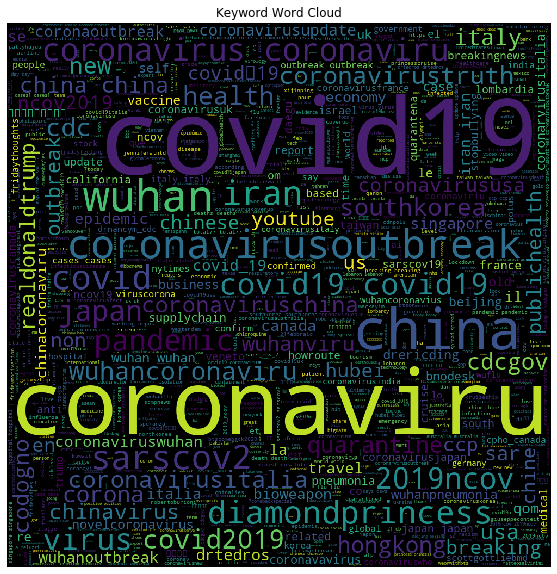

In [18]:
terms = Tfidf_vectorizer.get_feature_names()
wc = WordCloud(height=1000, width=1000, max_words=1000).generate("".join(terms))

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis("off")
plt.title("Keyword Word Cloud")
plt.show()

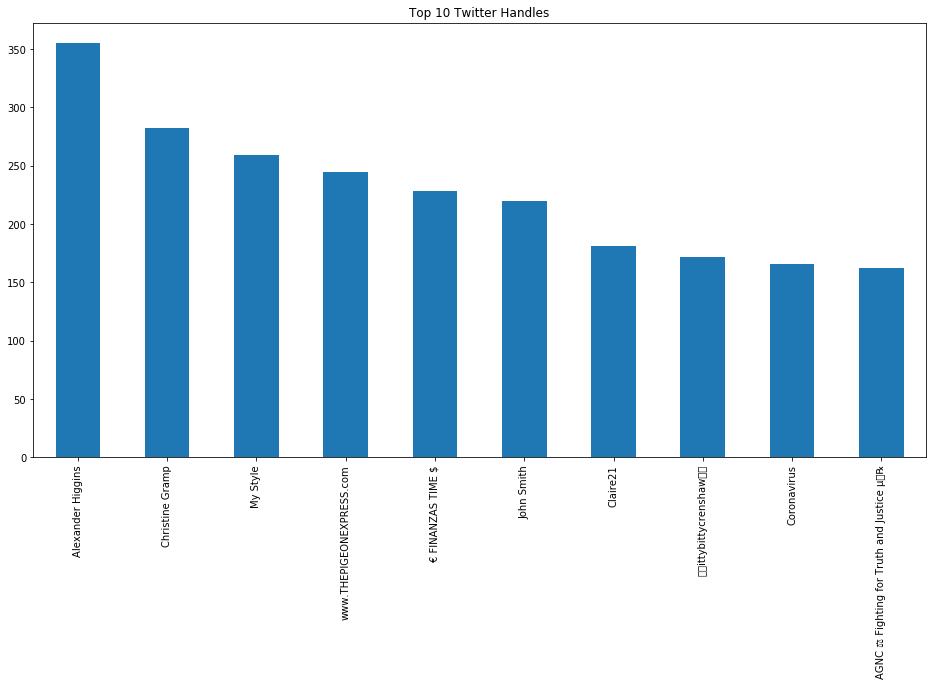

In [20]:
top_users = df.user_name.value_counts().sort_values(ascending=False)
top_users.head(10).plot.bar(title="Top 10 Twitter Handles", figsize=(16,8))